<a href="https://colab.research.google.com/github/LxMera/Convolutional-Neural-Network-for-the-classification-of-independent-components-of-rs-fMRI/blob/master/Get_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Hand-Training Datasets
Here are data sets of the human connectome project manually classified for FIX.

https://www.fmrib.ox.ac.uk/datasets/FIX-training/

### Connected to Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install tqdm
!pip install nilearn

import os
import cv2
import sys
import glob
import random
import warnings
import numpy as np
import pandas as pd
import nibabel as nib
import scipy.io as sio
from nilearn import image
from nilearn import plotting
from tqdm import tqdm
import tensorflow as tf
from itertools import chain
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.morphology import label
from tensorflow.keras.layers import Input
from tensorflow.keras import backend as K
from tensorflow.keras.layers import concatenate
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Flatten, Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from skimage.io import imread, imshow, imread_collection, concatenate_images
print (tf.__version__)
%matplotlib inline

     |████████████████████████████████| 2.5MB 4.5MB/s 


1.15.0


### Download data
\begin{bmatrix}
 & TR & Points & Points &  Points & Voxel-size & Field & Subjects & Shape\\ 
HCP-hp2000 & 0.7 & 1200 & - & - & 2×2×2mm & 3T & 100 & 91×109×91\\ 
HCP7T-hp2000 & 1.0 & - & - & - & 1.6×1.6×1.6mm & 7T &  &\\ 
Hand-clasifi & 2.0 & 242 & - & - & 3.4×3.4×3.0 mm & - &  &\\ 
Standar & 3.0 & 145 & 180 & 200 & 3.5×3.5×3.5mm & - &  &\\ 
Whii-MB6 & 1.3 & 460 & 1000 & - & 2×2×2mm & - & 39 & 106×106×72\\ 
Whii-Standar & 3.0 & 200 & - & - & 3×3×3mm & - &  &
\end{bmatrix}

In [0]:
gz=glob.glob('*.tar.gz')
files=np.shape(gz)[0]

if files==0:
  #Download
  #os.system('wget https://www.fmrib.ox.ac.uk/datasets/FIX-training/HCP_hp2000_runs1-20.tar.gz')
  #os.system('wget https://www.fmrib.ox.ac.uk/datasets/FIX-training/HCP_hp2000_runs21-40.tar.gz')
  #os.system('wget https://www.fmrib.ox.ac.uk/datasets/FIX-training/HCP_hp2000_runs41-60.tar.gz')
  #os.system('wget https://www.fmrib.ox.ac.uk/datasets/FIX-training/HCP_hp2000_runs61-80.tar.gz')
  #os.system('wget https://www.fmrib.ox.ac.uk/datasets/FIX-training/HCP_hp2000_runs81-100.tar.gz')  
  #os.system('wget https://www.fmrib.ox.ac.uk/datasets/FIX-training/HCP_hp2000_run1.tar.gz')
  #os.system('wget https://www.fmrib.ox.ac.uk/datasets/FIX-training/WhII_MB6.tar.gz')
  #os.system('wget https://www.fmrib.ox.ac.uk/datasets/FIX-training/WhII_Standard.tar.gz')
  os.system('wget https://www.fmrib.ox.ac.uk/datasets/FIX-training/Standard.tar.gz')
else:
  print('The files already exist')

### Find .tar files

In [4]:
compri=glob.glob('*.tar.gz')
print('tar.gz files ', np.shape(compri)[0])

if os.path.exists('AllData'):
  print('The folder already exist')
else:
  print('creating folder...')
  os.system('mkdir AllData')
  print('...folder AllData created.')

tar.gz files  1
creating folder...
...folder AllData created.


### Unzip Data

In [5]:
files=glob.glob('AllData/*')
folde=np.shape(files)[0]

if folde==0:
  for i in compri:
    print('unziping '+i+' in AllData')
    os.system('tar -xzvf '+i+' -C AllData')
    print('remove '+i)
    os.system('rm -r '+i)
else: 
  print('folders already unzipped')

unziping Standard.tar.gz in AllData
remove Standard.tar.gz


### Groups

In [6]:
Carpetas=np.sort(glob.glob('AllData/*'))
print(Carpetas)

['AllData/Standard']


### Subjects

In [7]:
for car in Carpetas:
  sujetos=glob.glob(car+'/*')
  print(np.shape(sujetos)[0],'Sujects on ', car)

106 Sujects on  AllData/Standard


# Get Data

### Images with PCA

In [0]:
from sklearn.decomposition import PCA
brain_pca = PCA(n_components=3)
scaler = StandardScaler()

def PCA_Images(imagex,k):
  imagex=ajuste(imagex)
  sag, cr, ax, cp=np.shape(imagex)
  if k>cp or k<0:
    print('The component number',str(k),' doesnt exist')
  #Axial
  brainF = np.zeros((1, sag*cr))
  ima3D=np.zeros((sag,cr,3))  
  for sl in range(ax):    
    slic=np.transpose(imagex[:,:,sl,k].flatten())
    brainF = np.concatenate((brainF,[slic]), axis=0)
  brainF=brainF[1:,:]  
  brain_pca.fit(brainF) 

  ima = np.transpose(brain_pca.components_)
  ima = np.transpose(scaler.fit_transform(ima))
  ima=(ima+1)*255/2
  ima[ima<0]=0
  ima[ima>255]=255 
  for chanel in range(3):
    ima3D[:,:,chanel]=ima[chanel].reshape(sag,cr)
  ima3D=np.array(ima3D, np.dtype('uint8'))

  #Coronal
  brainC = np.zeros((1, sag*ax))
  ima3C=np.zeros((sag,ax,3))  
  for sl in range(cr):    
    slic=np.transpose(imagex[:,sl,:,k].flatten())
    brainC = np.concatenate((brainC,[slic]), axis=0)
  brainC=brainC[1:,:]  
  brain_pca.fit(brainC) 

  imaC = np.transpose(brain_pca.components_)
  imaC = np.transpose(scaler.fit_transform(imaC))
  imaC=(imaC+1)*255/2
  imaC[imaC<0]=0
  imaC[imaC>255]=255 
  for chanel in range(3):
    ima3C[:,:,chanel]=imaC[chanel].reshape(sag,ax)
  ima3C=np.array(ima3C, np.dtype('uint8'))

  #Sagital
  brainS = np.zeros((1, cr*ax))
  ima3S=np.zeros((ax,cr,3))  
  for sl in range(sag):    
    slic=np.transpose(imagex[sl,:,:,k].flatten())
    brainS = np.concatenate((brainS,[slic]), axis=0)
  brainS=brainS[1:,:]  
  brain_pca.fit(brainS) 

  imaS = np.transpose(brain_pca.components_)
  imaS = np.transpose(scaler.fit_transform(imaS))
  imaS=(imaS+1)*255/2
  imaS[imaS<0]=0
  imaS[imaS>255]=255 
  for chanel in range(3):
    ima3S[:,:,chanel]=np.flip(np.transpose(imaS[chanel].reshape(cr,ax)))
  ima3S=np.array(ima3S, np.dtype('uint8'))
  #print(np.shape(ima3D), np.shape(ima3C), np.shape(ima3S) )
  imgn=cv2.hconcat([ima3D, ima3C, ima3S])
  return imgn

### Get PCA images in 3 axis

In [0]:
from sklearn.decomposition import PCA
brain_pca = PCA(n_components=3)
scaler = StandardScaler()

def segmentationPCA(imagex,k):
  sag, cr, ax, cp=np.shape(imagex)
  if k>cp or k<0:
    print('The component number',str(k),' doesnt exist')
  #Axial
  brainF = np.zeros((1, sag*cr))
  ima3D=np.zeros((sag,cr,3))  
  for sl in range(ax):   
    slic=np.transpose(imagex[:,:,sl,k].flatten())
    brainF = np.concatenate((brainF,[slic]), axis=0)
  brainF=brainF[1:,:]  
  brain_pca.fit(brainF) 

  ima = np.transpose(brain_pca.components_)
  ima = np.transpose(scaler.fit_transform(ima))
  ima=(ima+1)*255/2
  ima[ima<0]=0
  ima[ima>255]=255 
  for chanel in range(3):
    ima3D[:,:,chanel]=ima[chanel].reshape(sag,cr)
  ima3D=np.array(ima3D, np.dtype('uint8'))

  #Coronal
  brainC = np.zeros((1, sag*ax))
  ima3C=np.zeros((sag,ax,3))  
  for sl in range(cr):    
    slic=np.transpose(imagex[:,sl,:,k].flatten())
    brainC = np.concatenate((brainC,[slic]), axis=0)
  brainC=brainC[1:,:]  
  brain_pca.fit(brainC) 

  imaC = np.transpose(brain_pca.components_)
  imaC = np.transpose(scaler.fit_transform(imaC))
  imaC=(imaC+1)*255/2
  imaC[imaC<0]=0
  imaC[imaC>255]=255 
  for chanel in range(3):
    ima3C[:,:,chanel]=imaC[chanel].reshape(sag,ax)
  ima3C=np.array(ima3C, np.dtype('uint8'))

  #Saggital
  brainS = np.zeros((1, cr*ax))
  ima3S=np.zeros((cr,ax,3))  
  for sl in range(sag):    
    slic=np.transpose(imagex[sl,:,:,k].flatten())
    brainS = np.concatenate((brainS,[slic]), axis=0)
  brainS=brainS[1:,:]  
  brain_pca.fit(brainS) 

  imaS = np.transpose(brain_pca.components_)
  imaS = np.transpose(scaler.fit_transform(imaS))
  imaS=(imaS+1)*255/2
  imaS[imaS<0]=0
  imaS[imaS>255]=255 
  for chanel in range(3):
    ima3S[:,:,chanel]=imaS[chanel].reshape(cr,ax)
  ima3S=np.array(ima3S, np.dtype('uint8'))
  
  return ima3D, ima3C, ima3S

### Images with 3D threshold

In [0]:
kernel=np.ones((4,4))
umb=2
def threshold_3D(masx, umb, k):
  masx=ajuste(masx)
  sag, cr, ax, cp=np.shape(masx)

  #Axial
  ima3D=np.zeros((sag,cr,3))
  for z in range(8):
    val=2**z
    bina0=np.array((masx[:,:,int(11+z*3),k]>umb)*val, np.dtype('uint8'))
    bina0 = cv2.morphologyEx(bina0, cv2.MORPH_CLOSE, kernel)
    ima3D[:,:,0]=ima3D[:,:,0]+bina0

    bina1=np.array((masx[:,:,int(35+z*3),k]>umb)*val, np.dtype('uint8'))
    bina1 = cv2.morphologyEx(bina1, cv2.MORPH_CLOSE, kernel)
    ima3D[:,:,1]=ima3D[:,:,1]+bina1

    bina2=np.array((masx[:,:,int(59+z*3),k]>umb)*val, np.dtype('uint8'))
    bina2 = cv2.morphologyEx(bina2, cv2.MORPH_CLOSE, kernel)
    ima3D[:,:,2]=ima3D[:,:,2]+bina2

  #Coronal
  ima3C=np.zeros((sag,ax,3))
  for z in range(8):
    val=2**z
    bina0=np.array((masx[:,int(20+z*3),:,k]>umb)*val, np.dtype('uint8'))
    bina0 = cv2.morphologyEx(bina0, cv2.MORPH_CLOSE, kernel)
    ima3C[:,:,0]=ima3C[:,:,0]+bina0

    bina1=np.array((masx[:,int(44+z*3),:,k]>umb)*val, np.dtype('uint8'))
    bina1 = cv2.morphologyEx(bina1, cv2.MORPH_CLOSE, kernel)
    ima3C[:,:,1]=ima3C[:,:,1]+bina1

    bina2=np.array((masx[:,int(68+z*3),:,k]>umb)*val, np.dtype('uint8'))
    bina2 = cv2.morphologyEx(bina2, cv2.MORPH_CLOSE, kernel)
    ima3C[:,:,2]=ima3C[:,:,2]+bina2
  
  #sagittal
  ima3S=np.zeros((ax,cr,3))
  for z in range(8):
    val=2**z
    bina0=np.array((masx[int(11+z*3),:,:,k]>umb)*val, np.dtype('uint8'))
    bina0 = np.transpose(cv2.morphologyEx(bina0, cv2.MORPH_CLOSE, kernel))
    ima3S[:,:,0]=ima3S[:,:,0]+bina0

    bina1=np.array((masx[int(35+z*3),:,:,k]>umb)*val, np.dtype('uint8'))
    bina1 = np.transpose(cv2.morphologyEx(bina1, cv2.MORPH_CLOSE, kernel))
    ima3S[:,:,1]=ima3S[:,:,1]+bina1

    bina2=np.array((masx[int(59+z*3),:,:,k]>umb)*val, np.dtype('uint8'))
    bina2 = np.transpose(cv2.morphologyEx(bina2, cv2.MORPH_CLOSE, kernel))
    ima3S[:,:,2]=ima3S[:,:,2]+bina2
  imgn=cv2.hconcat([ima3D, ima3C, np.flip(ima3S)])
  imx=np.array(imgn, np.dtype('uint8'))  
  return imx

In [0]:
def ROI(pro):
  ima1=cv2.cvtColor(pro, cv2.COLOR_RGB2GRAY)
  color=ima1[0,0]
  ima1=np.array((ima1!=color), np.dtype('uint8'))
  contours,_ = cv2.findContours(ima1,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
  ind=0
  if np.shape(contours)[0]!=1:
    mx=[]
    for xi in range(np.shape(contours)[0]):
      area=cv2.contourArea(contours[xi])
      mx.append(area)
    ind=np.argmax(mx)
  x,y,w,h = cv2.boundingRect(contours[ind])
  return x,y,w,h

In [0]:
def savePCA(ima1, ima2, ima3, nam, cond=True):
  Ax=ROI(ima1)
  Cr=ROI(ima2)
  Sg=ROI(ima3)

  ima1=ima1[Ax[1]:Ax[1]+Ax[3],Ax[0]:Ax[0]+Ax[2],:]
  ima2=ima2[Cr[1]:Cr[1]+Cr[3],Cr[0]:Cr[0]+Cr[2],:]
  ima3=ima3[Sg[1]:Sg[1]+Sg[3],Sg[0]:Sg[0]+Sg[2],:]

  if cond:
    sio.savemat(nam+'.mat', {'Axial': ima1, 'Coronal': ima2, 'Saggital': ima3})
  return Ax, Cr, Sg

In [0]:
#Devuelve la imagen con contorno
def ROI2(pro):
  ima1=cv2.cvtColor(pro, cv2.COLOR_RGB2GRAY)
  color=ima1[0,0]
  ima1=np.array((ima1!=color), np.dtype('uint8'))
  contours,_ = cv2.findContours(ima1,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)

  print(np.shape(contours)[0])
  if np.shape(contours)[0]!=1:
    mx=[]
    for xi in range(np.shape(contours)[0]):
      area=cv2.contourArea(contours[xi])
      print(area)
      mx.append(area)
    print(np.argmax(mx))
    contours=contours[np.argmax(mx)]
  pro=cv2.drawContours(pro, contours, -1, (0,255,0), 1)
  return pro

In [0]:
def ShowPCA(ima1, ima2, ima3):
  Ax=ROI2(ima1)
  Cr=ROI2(ima2)
  Sg=ROI2(ima3)

  showImages(Ax, Cr, Sg)

In [0]:
def get_Axis(minx):
  Paxi=minx[0]
  Pcor=minx[1]
  Psag=minx[2]
  sg=Ds=cr=Dc=ax=Dx=0

  if Paxi[1]==Pcor[1] and Paxi[3]==Pcor[3]:
    sg=Paxi[1]
    Ds=Paxi[3]
  else:
    sg=np.min((Paxi[1],Pcor[1]))
    Ds=np.max((Paxi[3],Pcor[3]))

  if Paxi[0]==Psag[1] and Paxi[2]==Psag[3]:
    cr=Paxi[0]
    Dc=Paxi[2]
  else:
    cr=np.min((Paxi[0],Psag[1]))
    Dc=np.max((Paxi[2],Psag[3]))

  if Psag[0]==Pcor[0] and Psag[2]==Pcor[2]:
    ax=Pcor[0]
    Dx=Pcor[2]
  else:
    ax=np.min((Psag[0],Pcor[0]))
    Dx=np.max((Psag[2],Pcor[2]))
  return sg, Ds, cr, Dc, ax, Dx

In [0]:
def minimumVol(vol, roi):
  #Sagital, coronal, axial  
  vol=vol[roi[0]:roi[0]+roi[1],roi[2]:roi[2]+roi[3], roi[4]:roi[4]+roi[5],:]
  return vol

In [0]:
def showImages(i1, i2, i3):
  plt.figure(figsize=(25,5))
  plt.subplot(1,3,1)
  plt.imshow(i1)
  plt.axis('off')
  plt.subplot(1,3,2)
  plt.imshow(i2)
  plt.axis('off')
  plt.subplot(1,3,3)
  plt.imshow(i3)
  plt.axis('off')
  plt.show()

In [0]:
def ajuste(imagex):
  sx, cx, axx, cpx=np.shape(imagex)
  if sx!=axx:
    if sx<axx:
      dif=axx-sx
      pix=int(dif/2)
      if dif%2==0:        
        imagex=imagex[:,:,pix:-pix,:]
      else:
        imagex=imagex[:,:,1+pix:-pix,:]
    else:
      dif=sx-axx
      pix=int(dif/2)
      if dif%2==0:        
        imagex=imagex[pix:-pix,:,:,:]
      else:
        imagex=imagex[1+pix:-pix,:,:,:]
  return imagex

In [0]:
def ContourVector(pro):
  ima1=cv2.cvtColor(pro, cv2.COLOR_RGB2GRAY)
  color=ima1[0,0]
  ima1=np.array((ima1!=color), np.dtype('uint8'))
  contours,_ = cv2.findContours(ima1,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
  ind=0
  if np.shape(contours)[0]!=1:
    mx=[]
    for xi in range(np.shape(contours)[0]):
      area=cv2.contourArea(contours[xi])
      mx.append(area)
    ind=np.argmax(mx)
  cont=contours[ind]
  return cont

In [0]:
def getContours(im1, im2, im3):
  con1=ContourVector(im1)
  con2=ContourVector(im2)
  con3=ContourVector(im3)
  
  return con1, con2, con3

In [0]:
def ContourIma(con, ima):
  pro=ima.copy()
  pro=cv2.drawContours(pro, [con], 0, (0,0,255), 1)
  return pro

In [0]:
def rectangles(con1, con2, con3):
  Ax= cv2.boundingRect(con1)
  Cr= cv2.boundingRect(con2)
  Sg= cv2.boundingRect(con3)
  return Ax, Cr, Sg

In [0]:
#Saggital, coronal, axial
roundV=np.vectorize(round)
vecInt=np.vectorize(int)
def positions(rx):
  vS=vecInt(roundV(np.arange(rx[1]/48,rx[1],rx[1]/24.)))
  vC=vecInt(roundV(np.arange(rx[3]/48,rx[3],rx[3]/24.)))
  vA=vecInt(roundV(np.arange(rx[5]/48,rx[5],rx[5]/24.)))
  return vS, vC, vA

In [0]:
kernel=np.ones((4,4))
umb=2
def CompressVolumen(im,cmp,roi3):
  sag, cr, ax, cp=np.shape(im)

  vecs, vecc, veca=positions(roi3)
  veca=veca+roi3[4]
  vecc=vecc+roi3[2]
  vecs=vecs+roi3[0]
  #Axial
  ima3D=np.zeros((sag,cr,3), np.dtype('uint8'))
  for z in range(8):
    val=2**z
    bina0=np.array((im[:,:,veca[z],cmp]>umb)*val, np.dtype('uint8'))
    bina0 = cv2.morphologyEx(bina0, cv2.MORPH_CLOSE, kernel)
    ima3D[:,:,0]=ima3D[:,:,0]+bina0

    bina1=np.array((im[:,:,veca[8+z],cmp]>umb)*val, np.dtype('uint8'))
    bina1 = cv2.morphologyEx(bina1, cv2.MORPH_CLOSE, kernel)
    ima3D[:,:,1]=ima3D[:,:,1]+bina1

    bina2=np.array((im[:,:,veca[16+z],cmp]>umb)*val, np.dtype('uint8'))
    bina2 = cv2.morphologyEx(bina2, cv2.MORPH_CLOSE, kernel)
    ima3D[:,:,2]=ima3D[:,:,2]+bina2

  #Coronal
  ima3C=np.zeros((sag,ax,3), np.dtype('uint8'))
  for z in range(8):
    val=2**z
    bina0=np.array((im[:,vecc[z],:,cmp]>umb)*val, np.dtype('uint8'))
    bina0 = cv2.morphologyEx(bina0, cv2.MORPH_CLOSE, kernel)
    ima3C[:,:,0]=ima3C[:,:,0]+bina0

    bina1=np.array((im[:,vecc[8+z],:,cmp]>umb)*val, np.dtype('uint8'))
    bina1 = cv2.morphologyEx(bina1, cv2.MORPH_CLOSE, kernel)
    ima3C[:,:,1]=ima3C[:,:,1]+bina1

    bina2=np.array((im[:,vecc[16+z],:,cmp]>umb)*val, np.dtype('uint8'))
    bina2 = cv2.morphologyEx(bina2, cv2.MORPH_CLOSE, kernel)
    ima3C[:,:,2]=ima3C[:,:,2]+bina2
  
  #sagittal
  ima3S=np.zeros((cr, ax,3), np.dtype('uint8'))
  for z in range(8):
    val=2**z
    bina0=np.array((im[vecs[z],:,:,cmp]>umb)*val, np.dtype('uint8'))
    bina0 = cv2.morphologyEx(bina0, cv2.MORPH_CLOSE, kernel)
    ima3S[:,:,0]=ima3S[:,:,0]+bina0

    bina1=np.array((im[vecs[8+z],:,:,cmp]>umb)*val, np.dtype('uint8'))
    bina1 = cv2.morphologyEx(bina1, cv2.MORPH_CLOSE, kernel)
    ima3S[:,:,1]=ima3S[:,:,1]+bina1

    bina2=np.array((im[vecs[16+z],:,:,cmp]>umb)*val, np.dtype('uint8'))
    bina2 = cv2.morphologyEx(bina2, cv2.MORPH_CLOSE, kernel)
    ima3S[:,:,2]=ima3S[:,:,2]+bina2
   
  return ima3D, ima3C, ima3S

In [0]:
def filterBlur(im1, im2, im3):
  i1=cv2.medianBlur(im1, 7)
  i2=cv2.medianBlur(im2, 7)
  i3=cv2.medianBlur(im3, 7)
  return i1, i2, i3

In [0]:
def axisImages(im,cpx):
  sag, cr, ax, cp=np.shape(im)
  sx=int(sag/2)
  cx=int(cr/2)
  xa=int(ax/2)

  mx=15
  mi=-2

  im[im>mx]=mx
  im[im<mi]=mi

  im3=np.array((im[sx,:,:,cpx]-mi)*255/(mx-mi), np.dtype('uint8'))
  im2=np.array((im[:,cx,:,cpx]-mi)*255/(mx-mi), np.dtype('uint8'))
  im1=np.array((im[:,:,xa,cpx]-mi)*255/(mx-mi), np.dtype('uint8'))

  im1=cv2.cvtColor(im1, cv2.COLOR_GRAY2RGB)
  im2=cv2.cvtColor(im2, cv2.COLOR_GRAY2RGB)
  im3=cv2.cvtColor(im3, cv2.COLOR_GRAY2RGB)

  return im1, im2, im3

In [0]:
def ContourImages(im1, im2, im3, cn1, cn2, cn3):
  i1=ContourIma(cn1, im1)
  i2=ContourIma(cn2, im2)
  i3=ContourIma(cn3, im3)
  return i1, i2, i3

In [0]:
def CutImages(im1, im2, im3, minx):
  Paxi=minx[0]
  Pcor=minx[1]
  Psag=minx[2]
  
  i1=im1[Paxi[1]:Paxi[1]+Paxi[3],Paxi[0]:Paxi[0]+Paxi[2],:]
  i2=im2[Pcor[1]:Pcor[1]+Pcor[3],Pcor[0]:Pcor[0]+Pcor[2],:]
  i3=im3[Psag[1]:Psag[1]+Psag[3],Psag[0]:Psag[0]+Psag[2],:]

  return i1, i2, i3

In [0]:
def mainImages(prin, ncmp, fold, nome, sh=False, sav=False):
  imaA, imaC, imaS=segmentationPCA(prin,ncmp)

  conA, conC, conS=getContours(imaA, imaC, imaS)
  mini=rectangles(conA, conC, conS)
  roi=get_Axis(mini)

  CmaA, CmaC, CmaS=CompressVolumen(prin,ncmp,roi)
  fmaA, fmaC, fmaS=filterBlur(CmaA, CmaC, CmaS)
  AmaA, AmaC, AmaS=axisImages(prin,ncmp)

  res=ContourImages(imaA, imaC, imaS, conA, conC, conS)
  res1=ContourImages(CmaA, CmaC, CmaS, conA, conC, conS)
  res2=ContourImages(fmaA, fmaC, fmaS, conA, conC, conS)
  res3=ContourImages(AmaA, AmaC, AmaS, conA, conC, conS)

  xes=CutImages(imaA, imaC, imaS, mini)
  xes1=CutImages(CmaA, CmaC, CmaS, mini)
  xes2=CutImages(fmaA, fmaC, fmaS, mini)
  xes3=CutImages(AmaA, AmaC, AmaS, mini)

  res=CutImages(res[0], res[1], res[2], mini)
  res1=CutImages(res1[0], res1[1], res1[2], mini)
  res2=CutImages(res2[0], res2[1], res2[2], mini)
  res3=CutImages(res3[0], res3[1], res3[2], mini)

  if sav:
    sio.savemat(fold+'/PCA/'+nome+'.mat', {'saggital': xes[2], 'coronal': xes[1], 'axial': xes[0]})
    sio.savemat(fold+'/COM/'+nome+'.mat', {'saggital': xes1[2], 'coronal': xes1[1], 'axial': xes1[0]})
    sio.savemat(fold+'/BLU/'+nome+'.mat', {'saggital': xes2[2], 'coronal': xes2[1], 'axial': xes2[0]})
    sio.savemat(fold+'/AXI/'+nome+'.mat', {'saggital': xes3[2], 'coronal': xes3[1], 'axial': xes3[0]})

    sio.savemat(fold+'/C_PCA/'+nome+'.mat', {'saggital': res[2], 'coronal': res[1], 'axial': res[0]})
    sio.savemat(fold+'/C_COM/'+nome+'.mat', {'saggital': res1[2], 'coronal': res1[1], 'axial': res1[0]})
    sio.savemat(fold+'/C_BLU/'+nome+'.mat', {'saggital': res2[2], 'coronal': res2[1], 'axial': res2[0]})
    sio.savemat(fold+'/C_AXI/'+nome+'.mat', {'saggital': res3[2], 'coronal': res3[1], 'axial': res3[0]})
  
  if sh:
    plt.figure(figsize=(20,5)); plt.subplot(1,3,1); plt.imshow(res[0]); plt.subplot(1,3,2); plt.imshow(res[1]); plt.subplot(1,3,3); plt.imshow(res[2]); 
    plt.figure(figsize=(20,5)); plt.subplot(1,3,1); plt.imshow(res1[0]); plt.subplot(1,3,2); plt.imshow(res1[1]); plt.subplot(1,3,3); plt.imshow(res1[2]); 
    plt.figure(figsize=(20,5)); plt.subplot(1,3,1); plt.imshow(res2[0]); plt.subplot(1,3,2); plt.imshow(res2[1]); plt.subplot(1,3,3); plt.imshow(res2[2]); 
    plt.figure(figsize=(20,5)); plt.subplot(1,3,1); plt.imshow(res3[0]); plt.subplot(1,3,2); plt.imshow(res3[1]); plt.subplot(1,3,3); plt.imshow(res3[2]); 

    plt.figure(figsize=(20,5)); plt.subplot(1,3,1); plt.imshow(xes[0]); plt.subplot(1,3,2); plt.imshow(xes[1]); plt.subplot(1,3,3); plt.imshow(xes[2]); 
    plt.figure(figsize=(20,5)); plt.subplot(1,3,1); plt.imshow(xes1[0]); plt.subplot(1,3,2); plt.imshow(xes1[1]); plt.subplot(1,3,3); plt.imshow(xes1[2]); 
    plt.figure(figsize=(20,5)); plt.subplot(1,3,1); plt.imshow(xes2[0]); plt.subplot(1,3,2); plt.imshow(xes2[1]); plt.subplot(1,3,3); plt.imshow(xes2[2]); 
    plt.figure(figsize=(20,5)); plt.subplot(1,3,1); plt.imshow(xes3[0]); plt.subplot(1,3,2); plt.imshow(xes3[1]); plt.subplot(1,3,3); plt.imshow(xes3[2]); 

### test

saggital, coronal, axial and components (64, 64, 34, 51)
Time points  180


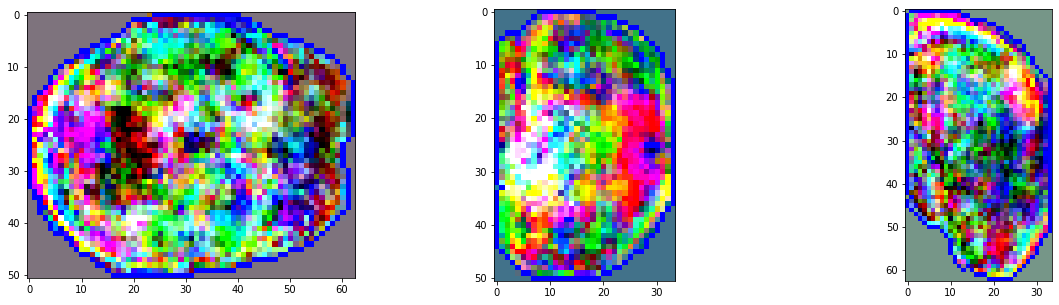

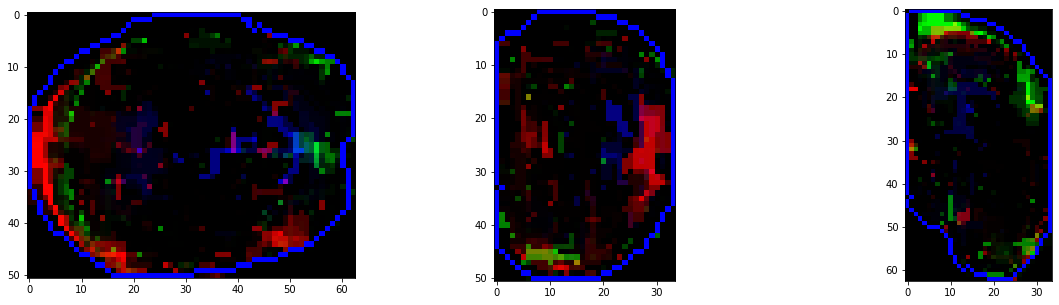

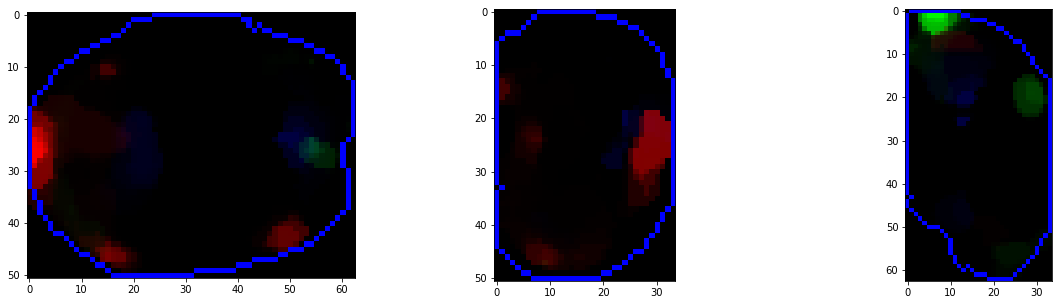

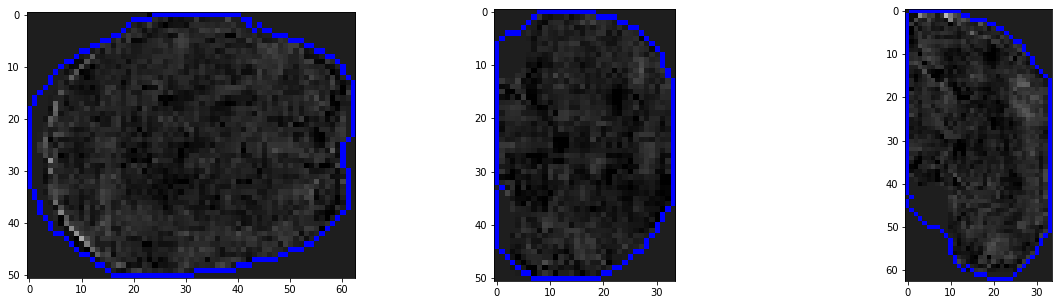

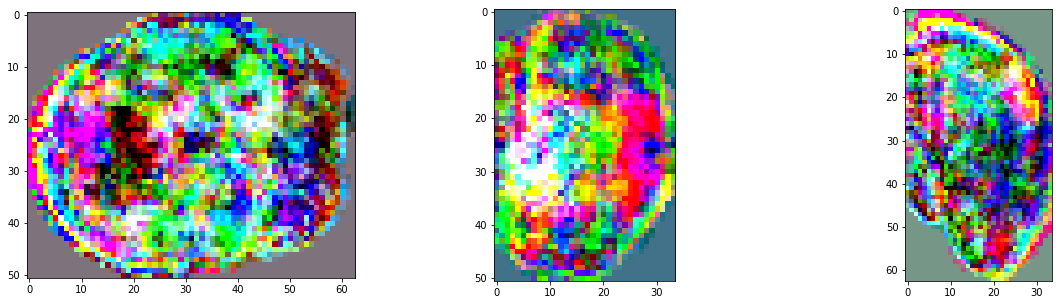

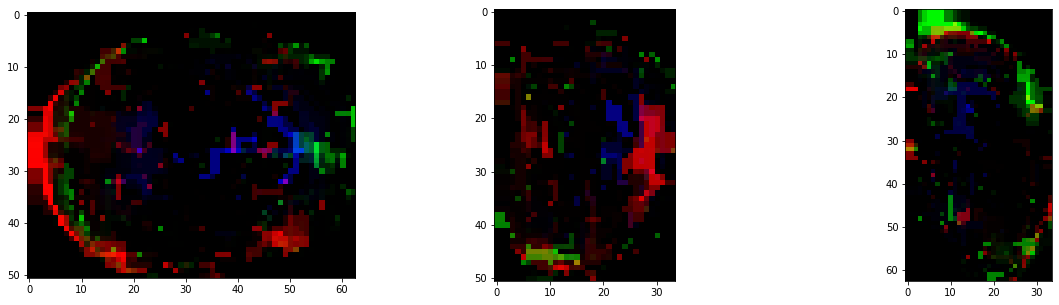

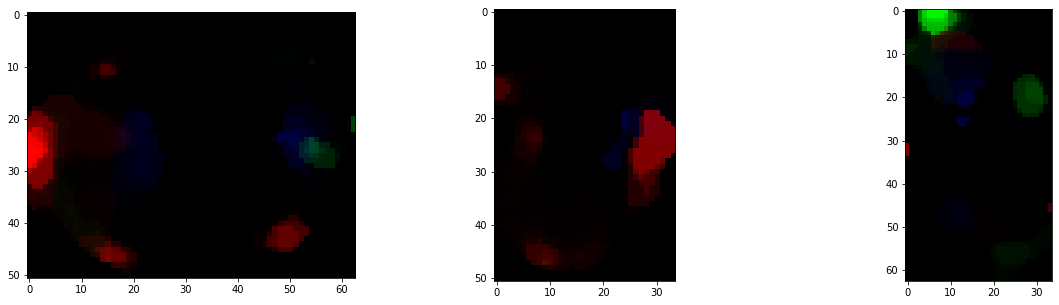

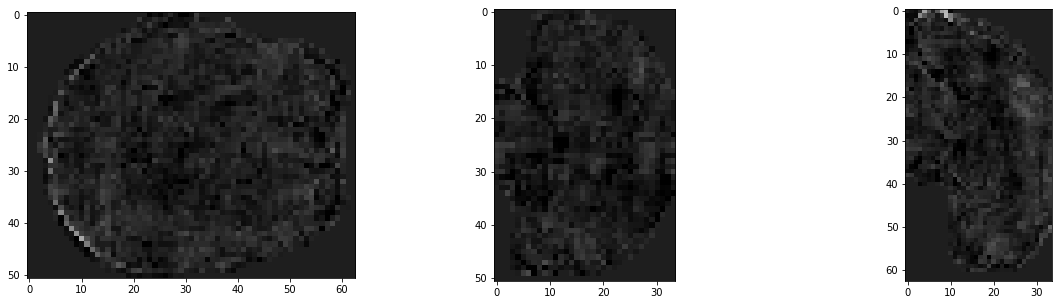

In [33]:
test=glob.glob('AllData/*/1.ica')[0]

img=image.image.load_img(test+'/filtered_func_data.ica/melodic_IC.nii.gz')      #Read data
series=np.loadtxt(test+"/filtered_func_data.ica/melodic_mix")                   #Read time serie
imasx=img.get_data()                                                            #Get volumen

print('saggital, coronal, axial and components', np.shape(imasx))
print('Time points ', np.shape(series)[0])

cp1=23
mainImages(imasx, cp1, 'HCP_hp2000', 'sub-1-comp-23', True, False)

In [31]:
np.shape(imasx)

(64, 64, 34, 51)

# Main

In [32]:
Tamanho=200
ext='drive/My\ Drive/DatosDeepImagenes/4-200'
umb=2
compSub=[]
conver=np.vectorize(int)
AllData=np.zeros((Tamanho,1))
AllLabels=[]
orden=[]
Axis=[]

for fx in Carpetas:
  subjects=glob.glob(fx+'/*')
  subjects=np.sort(subjects)
  os.system('mkdir '+ext+fx[8:]) #folder name
  os.system('mkdir '+ext+fx[8:]+'/PCA')
  os.system('mkdir '+ext+fx[8:]+'/COM')
  os.system('mkdir '+ext+fx[8:]+'/BLU')
  os.system('mkdir '+ext+fx[8:]+'/AXI')
  os.system('mkdir '+ext+fx[8:]+'/C_PCA')
  os.system('mkdir '+ext+fx[8:]+'/C_COM')
  os.system('mkdir '+ext+fx[8:]+'/C_BLU')
  os.system('mkdir '+ext+fx[8:]+'/C_AXI')
  ext='drive/My Drive/DatosDeepImagenes/4-200'

  for sub in subjects:
    ##--------------------------------x-----------------------------------------
    print(sub)
    series=np.loadtxt(sub+"/filtered_func_data.ica/melodic_mix")
    comp=np.shape(series)[1]
    print(comp)
    ##--------------------------------x-----------------------------------------
    
    ##--------------------------------x-----------------------------------------
    if np.shape(series)[0]==Tamanho:
      img=image.image.load_img(sub+"/filtered_func_data.ica/melodic_IC.nii.gz")    
      masx=img.get_data()
      
      for k in range(comp):
        name='sub-'+sub[len(fx)+1:-4]+'-comp-'+str(k)
        mainImages(masx, k, ext+fx[8:], name, False, True)
        print('|', end ="")
        orden.append(name)
    
    ##--------------------------------------------------------------------------

    ##--------------------------------------------------------------------------
    #print('Time and Components per subject ', np.shape(series))
    if np.shape(series)[0]==Tamanho:
      compSub.append(comp)
      #print('Time and Components per subject ', np.shape(series))
      label1=np.ones(comp)    
      AllData=np.concatenate((AllData,series), axis=1)
      
      #Leer etiquetas manuales
      f = open(sub+"/hand_labels_noise.txt") 
      while True:
        line = f.readline()
        if line=='':
          break
        handClas=line[1:-2]
      handClas= handClas.split(", ")
      handClas=conver(handClas)-1
      label1[handClas]=0
      AllLabels=np.concatenate((AllLabels, label1))
      #print('Noise per subject ', np.shape(handClas))
      f.close()
    ##--------------------------------------------------------------------------
    
AllData=AllData[:,1:]
sio.savemat(ext+fx[8:]+'/Time.mat', {'series': AllData})
sio.savemat(ext+fx[8:]+'/Labels.mat', {'labels': AllLabels})
sio.savemat(ext+fx[8:]+'/Order.mat', {'order': orden})

AllData/Standard/1.ica
51
AllData/Standard/10.ica
44
||||||||||||||||||||||||||||||||||||||||||||AllData/Standard/100.ica
61
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||AllData/Standard/101.ica
65
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||AllData/Standard/102.ica
70
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||AllData/Standard/103.ica
126
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||AllData/Standard/104.ica
68
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||AllData/Standard/105.ica
62
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||AllData/Standard/106.ica
71
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||AllData/Standard/11.ica
20
||||||||||||||||||||AllData/Standard/12.ica
40
||||||||||||||||||||||||||||||||||||||||AllData/Standard/13.ica
44
||||||||||||||||||||||||||||||||||||||||||